In [53]:
import ast
import numpy as np
import pandas as pd
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.calibration import CalibratedClassifierCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer, OneHotEncoder
from xgboost import XGBRFClassifier, XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('training_features.csv')

data['radiant_win'] = pd.read_csv('training_targets.csv')['radiant_win']

In [44]:
# Import the hero data and combine stats with each hero on r and d
hero_data = pd.read_csv('heroes_data.csv', index_col=0).drop(columns=['img', 'icon', 'name', 'localized_name', 'cm_enabled', 'base_health_regen'])

hero_data['roles'] = hero_data['roles'].apply(ast.literal_eval)

# Encode columns
bencoder = MultiLabelBinarizer()
tmp_data = bencoder.fit_transform(hero_data['roles'])

tmp_df = pd.DataFrame(
    tmp_data,
    columns=[f'role_{role}' for role in bencoder.classes_],
    index=hero_data.index
)

hero_data = pd.concat([hero_data, tmp_df], axis=1)

oencoder = OneHotEncoder(sparse_output=False)
tmp_data = oencoder.fit_transform(hero_data[['primary_attr', 'attack_type', 'main_role']])

tmp_df = pd.DataFrame(
    tmp_data,
    columns=oencoder.get_feature_names_out(),
    index=hero_data.index
)


# Drop the encoded columns
hero_data.drop(columns=['roles', 'primary_attr', 'attack_type', 'main_role'], inplace=True)

# Fill in base health
hero_data.fillna({'base_health': 0}, inplace=True)

for team in ['r', 'd']:
    for i in range(1, 6):
        data = data.merge(hero_data, left_on=f"{team}{i}_hero_id", right_on='id', suffixes=('', f'_{team}{i}'))
        data.drop(columns=['hero_id'], inplace=True)
        data.rename(columns={col: f"{col}_{team}{i}" for col in hero_data.columns if col != 'hero_id'}, inplace=True)


data.to_csv('processed_training_features_hero.csv', index=False)

In [45]:
# Encode the response variable
label_encoder = LabelEncoder()
data['radiant_win'] = label_encoder.fit_transform(data['radiant_win'])

In [46]:
def feature_selector(data):
    import numpy as np

    # ----- Player-level features -----
    for team in ['r', 'd']:
        for i in range(1, 6):
            kills = f'{team}{i}_kills'
            deaths = f'{team}{i}_deaths'
            assists = f'{team}{i}_assists'
            last_hits = f'{team}{i}_lh'
            kd_ratio = f'{team}{i}_kd_ratio'
            data[kd_ratio] = (data[kills] + data[assists] + data[last_hits]) / (data[deaths] + 1e-4)

    # ----- Team-level features -----
    team_stats = [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'xp', 'lh',
        'creeps_stacked', 'camps_stacked', 'rune_pickups',
        'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed'
    ]

    for team in ['r', 'd']:
        for stat in team_stats:
            cols = [f'{team}{i}_{stat}' for i in range(1, 6)]
            new_col = f'{team}_total_{stat}'
            data[new_col] = data[cols].sum(axis=1)

    data['game_time'] = data['game_time'].replace(0, 1e-4)

    cols_per_second = ['gold', 'xp', 'kills', 'deaths', 'lh',
                       'creeps_stacked', 'camps_stacked', 'rune_pickups',
                       'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']

    for team in ['r', 'd']:
        for col in cols_per_second:
            data[f'{team}_{col}_per_sec'] = data[f'{team}_total_{col}'] / data['game_time']

    # ----- Positional features -----
    for team in ['r', 'd']:
        data[f'{team}_mean_x'] = np.mean([data[f'{team}{i}_x'] for i in range(1, 6)], axis=0)
        data[f'{team}_mean_y'] = np.mean([data[f'{team}{i}_y'] for i in range(1, 6)], axis=0)
        x_spread = np.std([data[f'{team}{i}_x'] for i in range(1, 6)], axis=0)
        y_spread = np.std([data[f'{team}{i}_y'] for i in range(1, 6)], axis=0)
        data[f'{team}_x_spread'] = x_spread
        data[f'{team}_y_spread'] = y_spread
        data[f'{team}_spread'] = np.sqrt(x_spread ** 2 + y_spread ** 2)

    data['spread_advantage'] = data['r_spread'] - data['d_spread']

    # ----- Economy efficiency -----
    data["r_xp_to_gold_ratio"] = data["r_total_xp"] / (data["r_total_gold"] + 1e-6)
    data["r_gold_to_xp_ratio"] = data["r_total_gold"] / (data["r_total_xp"] + 1e-6)
    data["d_xp_to_gold_ratio"] = data["d_total_xp"] / (data["d_total_gold"] + 1e-6)
    data["d_gold_to_xp_ratio"] = data["d_total_gold"] / (data["d_total_xp"] + 1e-6)

    # ----- Team fighting / Objectives -----
    data["r_kill_participation"] = data["r_total_assists"] / (data["r_total_kills"] + 1e-4)
    data["d_kill_participation"] = data["d_total_assists"] / (data["d_total_kills"] + 1e-4)

    # ----- Denying / Farming efficiency -----
    data["r_lh_denies_per_sec"] = (data["r_total_lh"] + data["r_total_denies"]) / data["game_time"]
    data["d_lh_denies_per_sec"] = (data["d_total_lh"] + data["d_total_denies"]) / data["game_time"]

    # ----- Gold interaction terms -----
    data["gold_x_kills"] = data["r_total_gold"] * data["r_total_kills"]

    # ----- Log-transformed features -----
    data["log_r_gold"] = np.log1p(data["r_total_gold"])
    data["log_d_gold"] = np.log1p(data["d_total_gold"])

    # ----- R differences to D -----
    diff_cols = ['total_xp', 'total_gold', 'total_kills', 'total_deaths',
                 'total_assists', 'total_denies', 'total_lh', 'total_creeps_stacked',
                 'total_camps_stacked', 'total_rune_pickups', 'total_towers_killed',
                 'total_roshans_killed', 'total_obs_placed', 'total_sen_placed']
    for col in diff_cols:
        data[f'r_d_diff_{col}'] = data[f'r_{col}'] - data[f'd_{col}']
        data[f'r_d_sum_{col}'] = data[f'r_{col}'] + data[f'd_{col}']
        data[f'd_r_diff_{col}'] = data[f'd_{col}'] - data[f'r_{col}']

    # ----- Advantage Features -----
    data['gold_per_sec_advantage'] = data['r_gold_per_sec'] - data['d_gold_per_sec']
    data['kill_participation_advantage'] = data['r_kill_participation'] - data['d_kill_participation']
    data['r_deaths_per_gold'] = data['r_total_deaths'] / (data['r_total_gold'] + 1e-6)
    data['d_deaths_per_gold'] = data['d_total_deaths'] / (data['d_total_gold'] + 1e-6)
    data['farm_efficiency_r'] = (data['r_total_lh'] + data['r_total_denies']) / data['game_time']
    data['farm_efficiency_d'] = (data['d_total_lh'] + data['d_total_denies']) / data['game_time']
    data['r_objective_control'] = data['r_total_towers_killed'] + 2 * data['r_total_roshans_killed']
    data['d_objective_control'] = data['d_total_towers_killed'] + 2 * data['d_total_roshans_killed']
    data['objective_control_advantage'] = data['r_objective_control'] - data['d_objective_control']
    data['r_vision_score'] = data['r_total_obs_placed'] + data['r_total_sen_placed']
    data['d_vision_score'] = data['d_total_obs_placed'] + data['d_total_sen_placed']
    data['vision_score_advantage'] = data['r_vision_score'] - data['d_vision_score']

    # ----- Hero stat features -----
    hero_cols = ['base_str', 'base_agi', 'base_int', 'str_gain', 'agi_gain', 'int_gain',
                 'attack_range', 'attack_rate', 'move_speed', 'projectile_speed', 'attack_rate', 'winrate']
    for team in ['r', 'd']:
        for i in range(1, 6):
            for col in hero_cols:
                newcol = f'{col}_total_{team}'
                colname = f'{col}_{team}{i}'
                data[newcol] = data[colname]

    for col in hero_cols:
        newcol = f'{col}_total_sub'
        data[newcol] = data[f'{col}_total_r'] - data[f'{col}_total_d']

    # ----- NEW FEATURES -----
    data["xp_objectives_advantage"] = (data["r_total_xp"] * data["r_objective_control"] -
                                        data["d_total_xp"] * data["d_objective_control"])
    data["kill_death_ratio_r"] = data["r_total_kills"] / (data["r_total_deaths"] + 1e-6)
    data["kill_death_ratio_d"] = data["d_total_kills"] / (data["d_total_deaths"] + 1e-6)
    data["kill_death_ratio_advantage"] = data["kill_death_ratio_r"] - data["kill_death_ratio_d"]
    data["r_aggression_ratio"] = data["r_total_kills"] / (data["r_objective_control"] + 1e-6)
    data["d_aggression_ratio"] = data["d_total_kills"] / (data["d_objective_control"] + 1e-6)
    data["aggression_ratio_advantage"] = data["r_aggression_ratio"] - data["d_aggression_ratio"]
    data['r_objectives_per_xp'] = data['r_objective_control'] / (data['r_total_xp'] + 1e-6)
    data['d_objectives_per_xp'] = data['d_objective_control'] / (data['d_total_xp'] + 1e-6)
    data['objectives_per_xp_advantage'] = data['r_objectives_per_xp'] - data['d_objectives_per_xp']
    data['r_got_roshan'] = (data['r_total_roshans_killed'] > 0).astype(int)
    data['d_got_roshan'] = (data['d_total_roshans_killed'] > 0).astype(int)
    data['roshan_control_advantage'] = data['r_got_roshan'] - data['d_got_roshan']

    # ----- COMBINED SHAP FEATURES -----
    data['combined_gold_xp_diff'] = data['r_d_diff_total_gold'] + data['r_d_diff_total_xp']

    return data.copy()


In [47]:
filtered_data = feature_selector(data)

features = filtered_data.drop(columns=['radiant_win', 'match_id_hash'])
response = filtered_data['radiant_win']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
features = pd.DataFrame(scaled_features, columns=features.columns)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3, stratify=response, random_state=86)

print(f'Train Value Counts: {y_train.value_counts()}')
print(f'Test Value Counts: {y_test.value_counts()}')

Train Value Counts: radiant_win
1    10896
0     9876
Name: count, dtype: int64
Test Value Counts: radiant_win
1    4670
0    4233
Name: count, dtype: int64


In [48]:
# Feature selection
#selector = RFECV(
#   LogisticRegression(),
#   step=1,
#   cv=StratifiedKFold(5),
#   scoring='f1',
#   )
#selected_features = selector.fit(X_train, y_train)
#features_to_keep = X_train.columns[selected_features.support_]
#
#print(f'Selected features: {features_to_keep}')

features_to_drop = [
    "combined_gold_xp_diff",        # Redundant with weighted_econ_advantage
    "gold_per_sec_advantage",       # May exaggerate Radiant lead without context
    "r_d_diff_total_gold",          # Overlaps with other gold features
    "agi_gain_r3",                  # Low overall contribution, noisy at individual level
    "agi_gain_d4",
    "agi_gain_d3",
    "base_attack_min_r5",          # One player's stat — noisy on its own
    "r_mean_x",                    # Positional features with weak predictive signal
    "r_mean_y",
    "winrate_d1",                  # Single hero winrate is weak and patch-sensitive
    "d_r_diff_total_gold",         # Likely redundant and low impact
    "d_r_diff_total_xp",
    "d_rune_pickups_per_sec",      # Low impact, likely noise
    "r2_health",                   # Individual stat with low SHAP value
    "r_d_diff_total_xp",           # Weak contribution when weighted_econ_advantage is present
    "base_int_d3"                  # Another noisy hero stat
]

features_to_keep = X_train.drop(columns=features_to_drop) .columns


#features_to_keep =

Best Hyperparameters: {'colsample_bytree': 0.6013034768144452, 'gamma': 1.0354655203048657, 'learning_rate': 0.040527548660049185, 'max_depth': 4, 'n_estimators': 527, 'reg_alpha': 1.1381338286806102, 'reg_lambda': 3.3214098201721423, 'subsample': 0.7946089124002047}
Best Model Training F1 Score: 0.7613567866732424
Best Model Testing F1 Score: 0.661973633687444
Best threshold for F1: 0.2532374858856201
0.7705966587112172


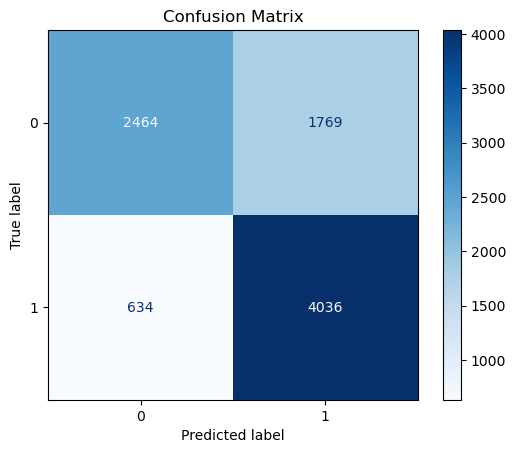

In [ ]:
# Create XGBRFClassifier model
hyper_params = {
    'n_estimators': randint(500, 2000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5.0),
    'reg_lambda': uniform(1e-3, 5.0),
    'reg_alpha': uniform(1e-3, 5.0),
    #'min_child_weight': randint(1, 10),
    #'booster': ['gbtree', 'dart']
}

xgbrf_model = RandomizedSearchCV(
    XGBClassifier(eval_metric='aucpr', scale_pos_weight=0.9),
    param_distributions=hyper_params,
    n_iter=10,
    scoring='precision',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=86),
    n_jobs=-1,
    random_state=86
)

xgbrf_model.fit(X_train[features_to_keep], y_train)
print(f"Best Hyperparameters: {xgbrf_model.best_params_}")

# Print the F1 score for test and training data
best_model_train_pred = xgbrf_model.predict(X_train[features_to_keep])
print(f"Best Model Training F1 Score: {f1_score(y_train, best_model_train_pred)}")
best_model_test_pred = xgbrf_model.predict(X_test[features_to_keep])
print(f"Best Model Testing F1 Score: {f1_score(y_test, best_model_test_pred)}")

# Save the best model
with open('xgbrf_model.pkl', 'wb') as f:
    pickle.dump(xgbrf_model, f)

y_probs = xgbrf_model.predict_proba(X_test[features_to_keep])[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[np.argmax(f1s)]
print(f"Best threshold for F1: {best_threshold}")

y_pred_best = (y_probs >= best_threshold).astype(int)
print(f1_score(y_test, y_pred_best))

# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbrf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


 96%|=================== | 1696/1769 [00:13<00:00]       

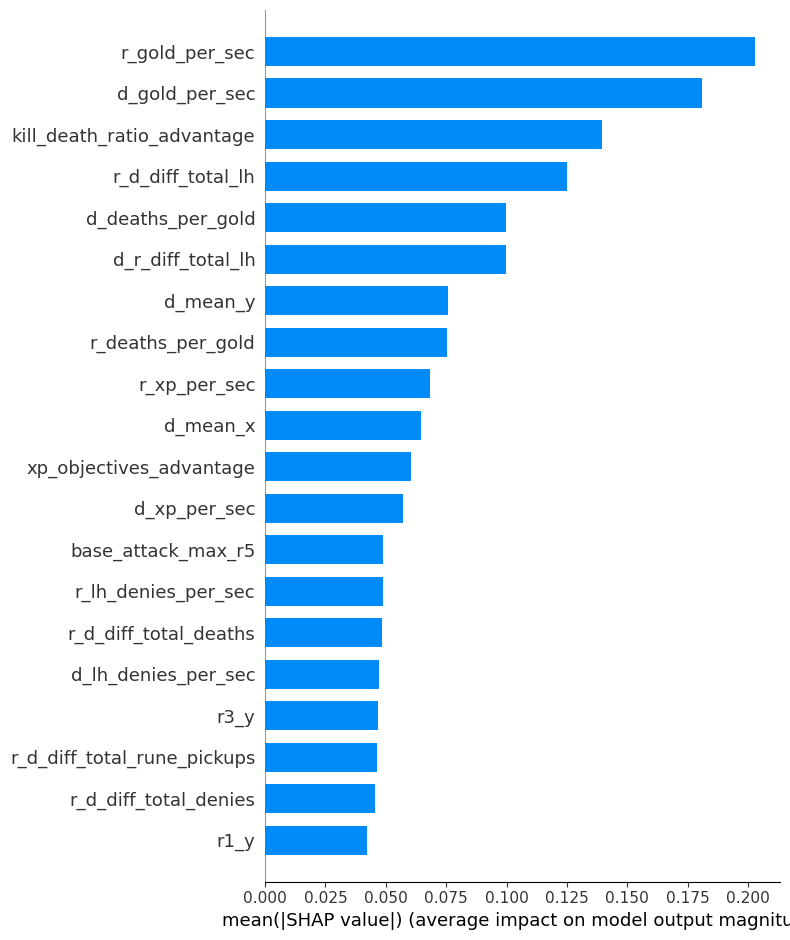

In [50]:
false_positives = np.where((y_test == 0) & (y_pred_best == 1))[0]

X_fp = X_test.iloc[false_positives][features_to_keep]

explainer = shap.Explainer(xgbrf_model.best_estimator_, X_train[features_to_keep])
shap_values_fp = explainer(X_fp)

shap.summary_plot(shap_values_fp, X_fp, plot_type="bar", max_display=20)


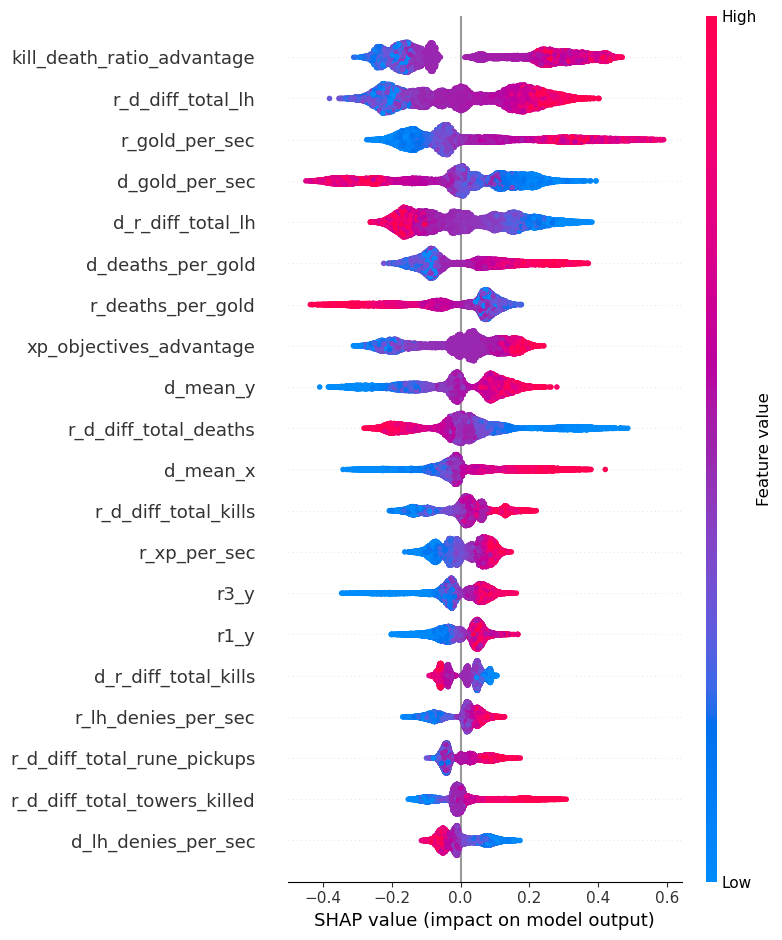

['kill_death_ratio_advantage',
 'r_d_diff_total_lh',
 'r_gold_per_sec',
 'd_gold_per_sec',
 'd_r_diff_total_lh',
 'd_deaths_per_gold',
 'r_deaths_per_gold',
 'xp_objectives_advantage',
 'd_mean_y',
 'r_d_diff_total_deaths',
 'd_mean_x',
 'r_d_diff_total_kills',
 'r_xp_per_sec',
 'r3_y',
 'r1_y',
 'd_r_diff_total_kills',
 'r_lh_denies_per_sec',
 'r_d_diff_total_rune_pickups',
 'r_d_diff_total_towers_killed',
 'd_lh_denies_per_sec',
 'r_d_diff_total_denies',
 'd_xp_per_sec',
 'base_attack_max_r5',
 'r_d_diff_total_assists',
 'r5_health',
 'r3_health',
 'd3_health',
 'd_towers_killed_per_sec',
 'd4_health',
 'r_rune_pickups_per_sec']

In [51]:
# SHAP
explainer = shap.TreeExplainer(xgbrf_model.best_estimator_)
shap_values = explainer.shap_values(X_train[features_to_keep])
shap.summary_plot(shap_values, X_train[features_to_keep])

shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X_train[features_to_keep].columns,
    'importance': shap_importance
}).sort_values(by='importance', ascending=False)
top_features = importance_df['feature'].tolist()[:30]

top_features


In [52]:
# Import the validation data
validation_data = pd.read_csv('test_features.csv')

processed_validation_data = feature_selector(validation_data)
processed_validation_data = processed_validation_data.drop(columns=[
                                                           'match_id_hash'])

# Make predictions on the validation data
validation_predictions = cat_model.predict_proba(
    processed_validation_data[features_to_keep])[:,1]

y_pred_best = (validation_predictions >= best_threshold).astype(int)

results = pd.DataFrame({
    'match_id_hash': validation_data['match_id_hash'],
    'radiant_win': label_encoder.inverse_transform(y_pred_best.flatten())
})
results.to_csv('submission.csv', index=False)

results.info()

KeyError: 'base_str_r1'